# Merge & Align NASA + Oxford Battery Datasets
This notebook loads processed NASA and Oxford battery datasets, aligns their features, merges them, and visualizes combined degradation curves.

In [22]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("Libraries loaded.")

Libraries loaded.


In [23]:
# --- 2. Load Processed Datasets ---
df_nasa = pd.read_csv('../data/processed/nasa_battery_degradation.csv')
df_oxford = pd.read_csv('../data/processed/oxford_battery_degradation.csv')

# Add dataset identifier
df_nasa['dataset'] = 'NASA'
df_oxford['dataset'] = 'Oxford'

print("Loaded datasets:")
print(f"NASA: {len(df_nasa)} rows")
print(f"Oxford: {len(df_oxford)} rows")

Loaded datasets:
NASA: 2794 rows
Oxford: 2076 rows


In [24]:
# --- 3. Inspect Column Names ---
print("\nNASA columns:")
print(df_nasa.columns.tolist())

print("\nOxford columns:")
print(df_oxford.columns.tolist())


NASA columns:
['battery_id', 'cycle_index', 'capacity', 'voltage', 'current', 'temperature', 'time', 'norm_capacity', 'RUL', 'dataset']

Oxford columns:
['battery_id', 'cycle_index', 'capacity', 'voltage', 'current', 'temperature', 'time', 'norm_capacity', 'RUL', 'dataset']


In [25]:
print(df_oxford.head())

  battery_id  cycle_index  capacity   voltage   current  temperature   time  \
0      Cell1            1  0.739111  3.819664       NaN    40.049519   3600   
1      Cell1            2  0.739111  3.735076 -0.739111    40.419340   3600   
2      Cell1            3  0.739111  3.793972       NaN    39.877812  64800   
3      Cell1            4  0.739820  3.769730 -0.041101    39.901900  64800   
4      Cell1            5  0.739820  3.821715       NaN    39.993983   3600   

   norm_capacity  RUL dataset  
0       0.999042  311  Oxford  
1       0.999042  310  Oxford  
2       0.999042  309  Oxford  
3       1.000000  308  Oxford  
4       1.000000  307  Oxford  


In [26]:
df_nasa.columns.tolist()

['battery_id',
 'cycle_index',
 'capacity',
 'voltage',
 'current',
 'temperature',
 'time',
 'norm_capacity',
 'RUL',
 'dataset']

In [27]:
# --- 4. Standardize Column Names ---
# Rename Oxford columns to match NASA format
df_oxford.rename(columns={
    'Cycle_Index': 'cycle_index',
    'Capacity_Ah': 'capacity',
    'Battery_ID': 'battery_id'
}, inplace=True)

# Select only relevant columns
cols_to_keep = ['battery_id', 'cycle_index', 'capacity', 'norm_capacity', 'RUL', 'dataset']
df_nasa = df_nasa[cols_to_keep]
df_oxford = df_oxford[cols_to_keep]

print("Columns aligned.")

Columns aligned.


In [28]:
# --- 5. Combine Datasets ---
df_combined = pd.concat([df_nasa, df_oxford], ignore_index=True)
print(f"Merged dataset size: {len(df_combined)} rows")

Merged dataset size: 4870 rows


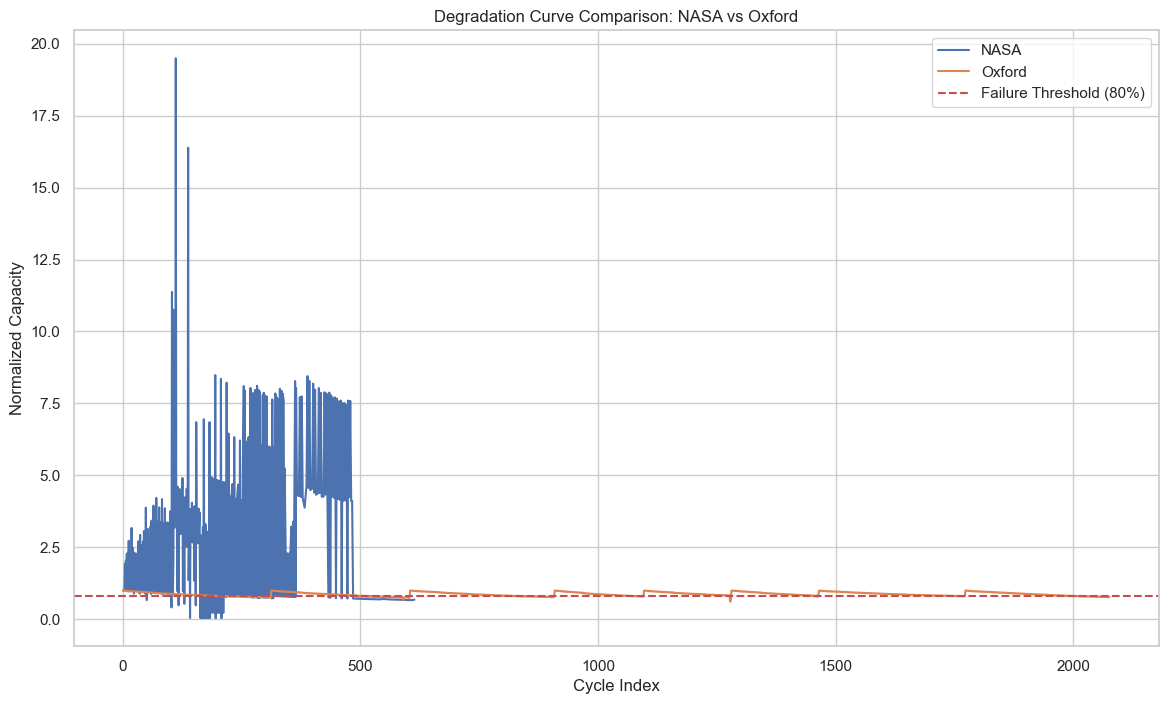

In [29]:
# --- 6. Visualize Combined Degradation Curves ---
plt.figure(figsize=(14, 8))
datasets_to_plot = ['NASA', 'Oxford']
for dataset in datasets_to_plot:
    subset = df_combined[df_combined['dataset'] == dataset].groupby('cycle_index')['norm_capacity'].mean().reset_index()
    plt.plot(subset['cycle_index'], subset['norm_capacity'], label=dataset)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)')
plt.xlabel('Cycle Index')
plt.ylabel('Normalized Capacity')
plt.title('Degradation Curve Comparison: NASA vs Oxford')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# --- 7. Save Merged Dataset ---
output_path = '../data/processed/merged_battery_degradation.csv'
df_combined.to_csv(output_path, index=False)
print(f"Merged dataset saved to {output_path}")

Merged dataset saved to ../data/processed/merged_battery_degradation.csv
